In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv('train.csv',usecols=['Age','Fare','Survived'])

In [3]:
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [5]:
df.shape

(891, 3)

**we will drop all the rows where there are missing values**

In [6]:
df.dropna(inplace=True)

In [7]:
df.shape

(714, 3)

In [9]:
# no of missing rows in age column = 177
891-177

714

In [10]:
X = df.iloc[:,1:3]
y = df.iloc[:,0]

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [12]:
X_train.head(2)

,Age,Fare
328,31.0,20.5250
73,26.0,14.4542


**Before binning**

In [13]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.6223776223776224

In [14]:
np.mean(cross_val_score(clf,X,y,cv=10,scoring='accuracy'))

np.float64(0.63589593114241)

In [16]:
kbin_age = KBinsDiscretizer(
    n_bins=15,
    encode = 'ordinal',
    strategy = 'quantile'
)

kbin_fare = KBinsDiscretizer(
    n_bins = 15,
    encode = 'ordinal',
    strategy = 'quantile'
)

In [17]:
trf = ColumnTransformer([
    ('first',kbin_age,[0]),
    ('second',kbin_fare,[1])
], remainder='passthrough')

In [18]:
X_train_transformed = trf.fit_transform(X_train)
X_test_transformed = trf.transform(X_test)

In [19]:
trf.named_transformers_

{'first': KBinsDiscretizer(encode='ordinal', n_bins=15),
 'second': KBinsDiscretizer(encode='ordinal', n_bins=15)}

In [20]:
trf.named_transformers_['first']

KBinsDiscretizer(encode='ordinal', n_bins=15)

In [21]:
trf.named_transformers_['first'].bin_edges_

array([array([ 0.42,  6.  , 16.  , 19.  , 21.  , 23.  , 25.  , 28.  , 30.  ,
              32.  , 35.  , 38.  , 42.  , 47.  , 54.  , 80.  ])             ],
      dtype=object)

**we will have the same number of people per bin, but their ages can be different, i.e intervals can be different**

1. if we have 15 bins then it becomes 1/15 *100 = 6.67%
2. so we will have 6.67% of population in each bin
3. 0.42 -> 6 (6.67% of population) ,
6 -> 16 (6.67% of population)
0.42 -> 16 (13.33% of the population falls into bins covering 0.42 → 16)

4. Quantile binning = Equal number of samples,Unequal interval widths

In [22]:
trf.named_transformers_['second'].bin_edges_

array([array([  0.    ,   7.25  ,   7.775 ,   7.8958,   8.1583,  10.5   ,
               13.    ,  14.4542,  18.75  ,  26.    ,  26.55  ,  31.275 ,
               51.4792,  76.2917, 108.9   , 512.3292])                   ],
      dtype=object)

In [23]:
output = pd.DataFrame({
    'age' : X_train['Age'],
    'age_trf' : X_train_transformed[:,0],
    'fare' : X_train['Fare'],
    'fare_trf' : X_train_transformed[:,1]
})

> pandas.cut
pandas.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True)[source]
Bin values into discrete intervals.

Use cut when you need to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable. For example, cut could convert ages to groups of age ranges. Supports binning into an equal number of bins, or a pre-specified array of bins.

> Parameters
:
> (x)
  1d ndarray or Series
  The input array to be binned. Must be 1-dimensional.

> (bins)
  int, sequence of scalars, or IntervalIndex
  The criteria to bin by.

  1. int : Defines the number of equal-width bins in the range of x. The range of x is extended by .1% on each side to include the minimum and maximum values of x.

  2. sequence of scalars : Defines the bin edges allowing for non-uniform width. No extension of the range of x is done.

  3. IntervalIndex : Defines the exact bins to be used. Note that IntervalIndex for bins must be non-overlapping.



> right
bool, default True
Indicates whether bins includes the rightmost edge or not. If right == True (the default), then the bins [1, 2, 3, 4] indicate (1,2], (2,3], (3,4]. This argument is ignored when bins is an IntervalIndex.

**here we use bins as sequence of scalars i.e bin edges**

In [31]:
trf.named_transformers_['first'].bin_edges_[0]

array([ 0.42,  6.  , 16.  , 19.  , 21.  , 23.  , 25.  , 28.  , 30.  ,
       32.  , 35.  , 38.  , 42.  , 47.  , 54.  , 80.  ])

In [32]:
output['age_labels'] = pd.cut(
    x = X_train['Age'],
    bins = trf.named_transformers_['first'].bin_edges_[0].tolist()
)

output['fare_labels'] = pd.cut(
    x = X_train['Fare'],
    bins = trf.named_transformers_['second'].bin_edges_[0].tolist()
)

In [33]:
output.sample(5)

,age,age_trf,fare,fare_trf,age_labels,fare_labels
183,1.0,0.0,39.0000,11.0,"(0.42, 6.0]","(31.275, 51.479]"
456,65.0,14.0,26.5500,10.0,"(54.0, 80.0]","(26.0, 26.55]"
33,66.0,14.0,10.5000,5.0,"(54.0, 80.0]","(8.158, 10.5]"
609,40.0,11.0,153.4625,14.0,"(38.0, 42.0]","(108.9, 512.329]"
879,56.0,14.0,83.1583,13.0,"(54.0, 80.0]","(76.292, 108.9]"


In [34]:
clf = DecisionTreeClassifier()
clf.fit(X_train_transformed,y_train)
y_pred2 = clf.predict(X_test_transformed)
accuracy_score(y_test,y_pred2)

0.6363636363636364

In [35]:
X.head(1)

,Age,Fare
0,22.0,7.25


In [36]:
X_trf = trf.fit_transform(X)
clf = DecisionTreeClassifier()
np.mean(cross_val_score(clf,X_trf,y,cv=10,scoring='accuracy'))

np.float64(0.6723004694835681)

In [43]:
def discretize(bins,strategy):
  kbin_age = KBinsDiscretizer(
      n_bins = bins,
      encode = 'ordinal',
      strategy = strategy
  )

  kbin_fare = KBinsDiscretizer(
      n_bins = bins,
      encode = 'ordinal',
      strategy = strategy
  )

  trf = ColumnTransformer([
      ('first',kbin_age,[0]),
      ('second',kbin_fare,[1])
  ],remainder='passthrough')

  X_trf = trf.fit_transform(X)
  print(np.mean(cross_val_score(
      DecisionTreeClassifier(),
      X_trf,
      y,
      cv = 10,
      scoring = 'accuracy'
  )))

  plt.figure(figsize=(14,4))
  plt.subplot(121)
  plt.hist(X['Age'])
  plt.title('Age Before Binning')

  plt.subplot(122)
  plt.hist(X_trf[:,0],color='red')
  plt.title('Age After Binning')

  plt.show()

  plt.figure(figsize=(14,4))
  plt.subplot(121)
  plt.hist(X['Fare'])
  plt.title('Fare Before Binning')

  plt.subplot(122)
  plt.hist(X_trf[:,1],color='red')
  plt.title('Fare After Binning')

  plt.show()

0.6723982785602504


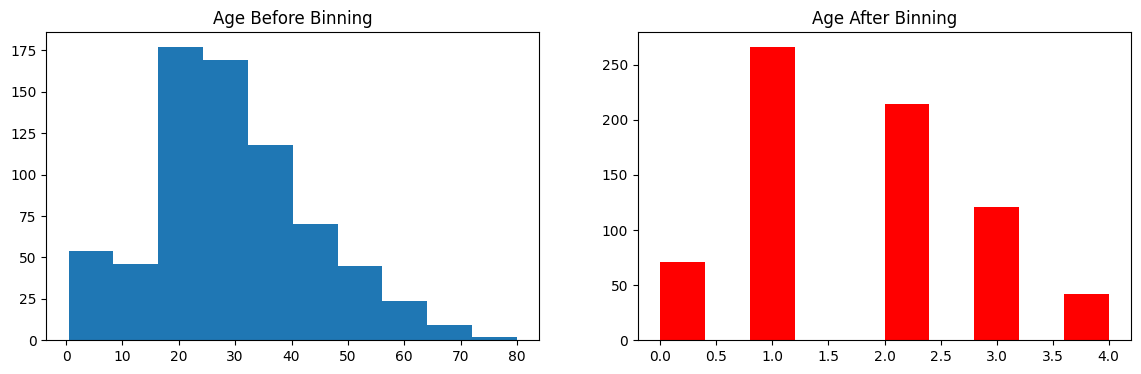

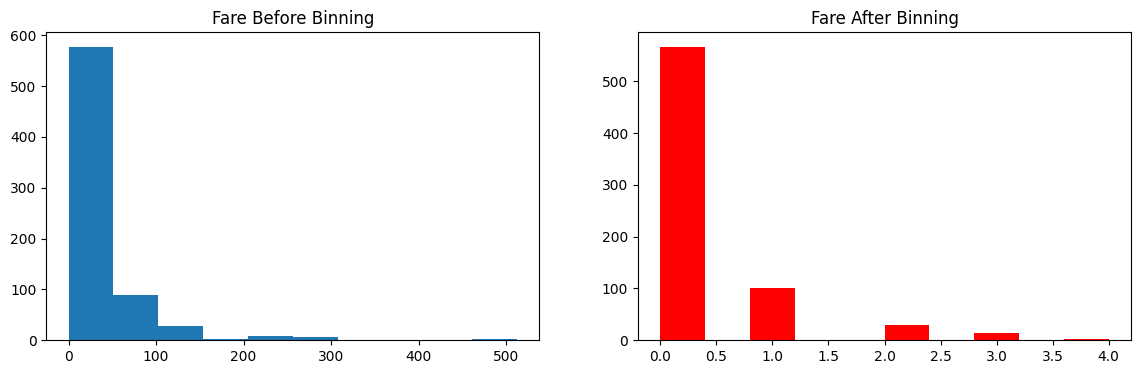

In [44]:
discretize(5,'kmeans')

0.6723004694835681


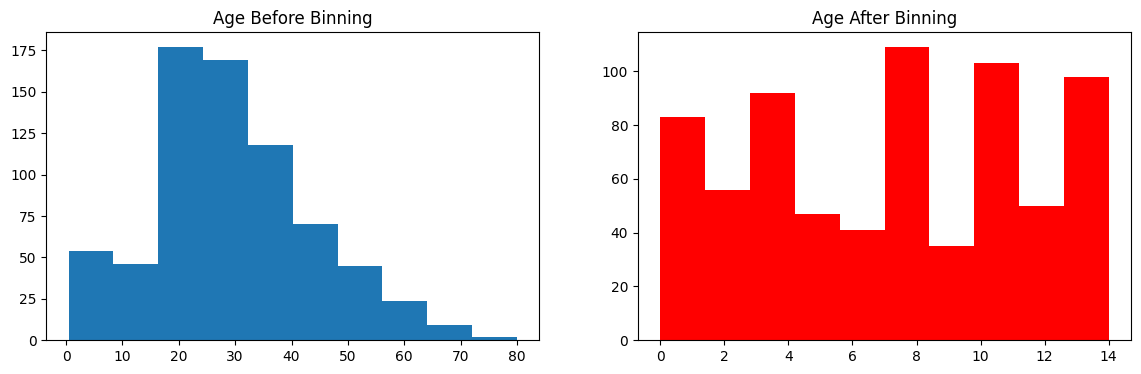

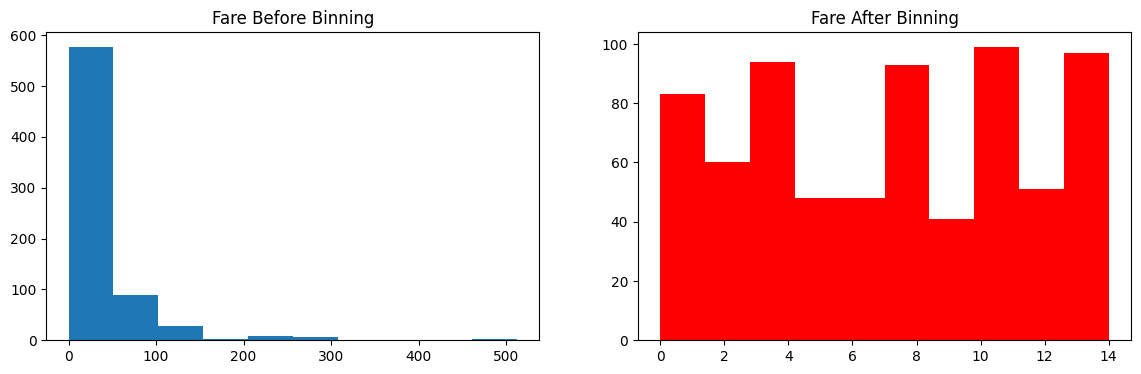

In [45]:
discretize(15,'quantile')

0.6541275430359936


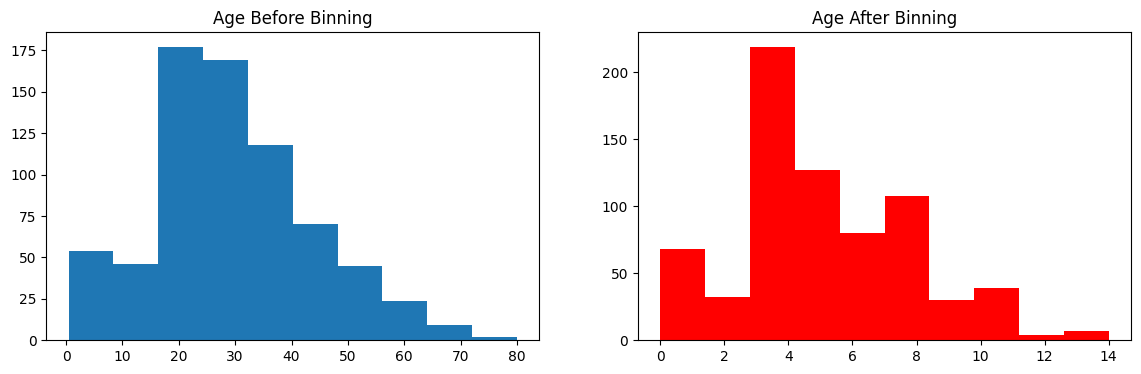

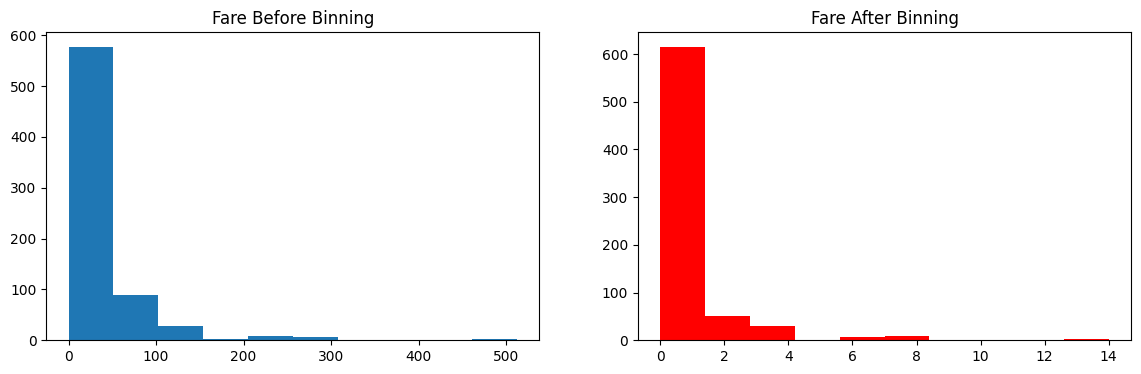

In [46]:
discretize(15,'uniform')